In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [2]:
from pathlib import Path
import argparse
import wandb
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
# import hvplot.xarray

import tensorflow as tf
import tensorflow_datasets as tfd
import jax
import jax.random as jrandom
import jax.numpy as jnp
import equinox as eqx
from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.gp_tf import add_model_args, get_likelihood, get_kernel, get_inducing_points
from loss import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizer import add_optimizer_gpflow_args
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics
from smoke_test import add_winter_smoke_test_args, add_january_smoke_test_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

2022-06-03 15:31:39.060219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 15:31:39.060258: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Arguments

In [3]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_gpflow_args(parser)
parser = add_loss_args(parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"

# subset
args.feature_scaler = "standard"
args.model = "svgp"
args.smoke_test = True
args.wandb_mode = "online"
args.wandb_resume = True
args.id = None # "2uuq7tks"
args.batch_size = 2048
args.n_epochs = 10
args.learning_rate = 1e-2

args = add_january_smoke_test_args(args)
# args = add_winter_smoke_test_args(args)

### Logger


In [4]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (ige). Use `wandb login --relogin` to force relogin
2022-06-03 15:31:47.665730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### Load Data

In [5]:
%%time

# load data
data = load_data(args)

# preprocess data
data = preprocess_data(data, args)

# feature transformation
data, scaler = feature_transform(data, args)

100%|██████████| 6/6 [00:00<00:00, 21.85it/s]


CPU times: user 684 ms, sys: 280 ms, total: 964 ms
Wall time: 1.21 s


In [6]:
data[data.attrs["input_cols"]].head()

,longitude,latitude,time
0,1.600540,0.545403,-1.706420
1,1.598256,0.552926,-1.706420
2,1.595968,0.560448,-1.706419
3,1.593677,0.567970,-1.706418
4,1.591384,0.575492,-1.706418


In [7]:
data[data.attrs["input_cols"]].describe()

,longitude,latitude,time
count,2.835390e+05,2.835390e+05,2.835390e+05
mean,-4.498517e-13,9.988473e-15,-1.240917e-09
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.945946e+00,-1.642479e+00,-1.706420e+00
25%,-8.227600e-01,-8.426432e-01,-8.609840e-01
50%,5.412140e-02,-5.230742e-02,-2.617701e-02
75%,8.788459e-01,7.522707e-01,8.565812e-01
max,1.601480e+00,2.220775e+00,1.760150e+00


In [8]:
%%time


# extract data
xtrain = data[data.attrs["input_cols"]].values
ytrain = data[data.attrs["output_cols"]].values

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]


if args.smoke_test:
    rng = np.random.RandomState(args.split_seed)
    idx = rng.choice(np.arange(args.n_train), size=2_000)
    xtrain = xtrain[idx]
    ytrain = ytrain[idx]

# rng = np.random.RandomState(args.split_seed+10)
# idx = rng.choice(np.arange(args.n_valid), size=1_000)
# xvalid = xvalid[idx]
# yvalid = yvalid[idx]

    
wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
    }
)
print(f"N Training: {xtrain.shape[0]:_}")

N Training: 2_000
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.47 ms


## Model - Stochastic Variational GP

In [9]:
import gpflow
import gpflux
import numpy as np
from gpflow.utilities import print_summary
from tqdm.notebook import trange

# # Ensure TF does not see GPU and grab all GPU memory.
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2022-06-03 15:31:51.496047: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 15:31:51.496081: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 15:31:51.496101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ige-meom-cal1): /proc/driver/nvidia/version does not exist


In [10]:
def make_ds(shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (xtrain.astype(np.float64), ytrain.astype(np.float64))
    )

    
    ds = ds.prefetch(args.prefetch_buffer)
    ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * args.batch_size)
    ds = ds.batch(args.batch_size)
    
    
    return iter(ds)

In [11]:
ds_train = make_ds()    

2022-06-03 15:31:51.610278: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# get kernel
kernel = get_kernel(args)
# get likelihood
likelihood = get_likelihood(args)
# get inducing points
Z = get_inducing_points(xtrain, args)


# don't train the inducing inputs
model = gpflow.models.SVGP(kernel, likelihood, Z.astype(np.float64), num_data=xtrain.shape[0])

# train the inducing inputs
gpflow.set_trainable(model.inducing_variable, True)

2022-06-03 15:31:51.733043: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [13]:
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤═══════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                     │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪═══════════════════════════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.0                                       │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼───────────────────────────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)          │ float64 │ [7. 1. 1.]                                │
├──────────────────────────┼───────────┼──────────────────┼─────────┼───────

In [14]:
from gpflow import set_trainable
from gpflow.optimizers import NaturalGradient




# Create an Adam Optimizer
ordinary_adam_opt = tf.optimizers.Adam(args.learning_rate)


# NatGrads and Adam for SVGP
# Stop Adam from optimizing the variational parameters
set_trainable(model.q_mu, False)
set_trainable(model.q_sqrt, False)

# Create the optimize_tensors for SVGP
adam_opt = tf.optimizers.Adam(args.learning_rate)

natgrad_opt = NaturalGradient(gamma=args.learning_rate_ng)
variational_params = [(model.q_mu, model.q_sqrt)]


# make training loss
training_loss = model.training_loss_closure(ds_train, compile=True)

In [15]:
n_steps_per_epoch = args.n_train / args.batch_size
steps = int(n_steps_per_epoch * args.n_epochs) if not args.smoke_test else 500


wandb.config.update(
    {
        "steps": steps,
        "n_steps_per_epoch": n_steps_per_epoch,
    }
)

In [16]:

# # make dataset
# ds_train = make_ds()

# # don't train the inducing inputs
# # create gp model
# model = gpflow.models.SVGP(kernel, likelihood, Z.astype(np.float64), num_data=xtrain.shape[0])
# gpflow.set_trainable(model.inducing_variable, False)


# # Create an Adam Optimizer
# losses["standard"] = []
# optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)

# # make training loss
# training_loss = model.training_loss_closure(ds_train, compile=True)


# @tf.function
# def optimization_step():
#     optimizer.minimize(training_loss, model.trainable_variables)

# with trange(steps) as pbar:
#     for step in pbar:
#         optimization_step()
#         elbo = -training_loss().numpy()
#         losses["standard"].append(elbo)
#         wandb.log({"elbo": elbo}, step=step)
        
#         if step % 10 == 0:
#             pbar.set_description(f"Loss (ELBO): {elbo:.4e}")
            
            

In [17]:
losses = []
@tf.function
def optimization_step():
    adam_opt.minimize(training_loss, var_list=model.trainable_variables)

@tf.function
def natgrad_optimization_step():
    natgrad_opt.minimize(training_loss, var_list=variational_params)
    
with trange(steps) as pbar:
    for step in pbar:
        optimization_step()
        natgrad_optimization_step()
        elbo = -training_loss().numpy()
        losses.append(elbo)
        wandb.log({"elbo": elbo}, step=step)
        
        if step % 10 == 0:
            pbar.set_description(f"Loss (ELBO): {elbo:.4e}")

  0%|          | 0/500 [00:00<?, ?it/s]

2022-06-03 15:31:56.207798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-03 15:31:56.246389: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


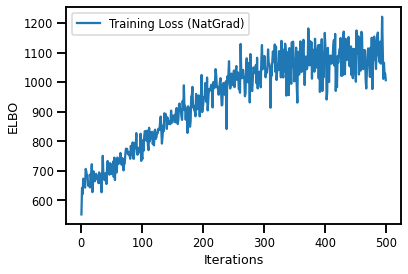

In [18]:
fig, ax = plt.subplots()

ax.plot(losses, label="Training Loss (NatGrad)")
ax.set(xlabel="Iterations", ylabel="ELBO")
plt.legend()
plt.show()

In [19]:
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤════════════════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                  │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪════════════════════════════════════════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.9307501305151612                                     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼────────────────────────────────────────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)          │ float64 │ [9.12219912 2.3079613  2.72851319]                     

In [20]:
# objects
path_model = Path(wandb.run.dir).joinpath("model.pickle")
path_scaler = Path(wandb.run.dir).joinpath("scaler.pickle")

# models to save
save_object(gpflow.utilities.parameter_dict(model), path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_model), policy="now")
wandb.save(str(path_scaler), policy="now")

['./wandb/run-20220603_153145-zlx895gq/files/wandb/run-20220603_153145-zlx895gq/files/scaler.pickle']

In [21]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb.run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.entity}/{args.project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    "model.pickle"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [22]:
params = load_object("./model.pickle")
scaler = load_object("./scaler.pickle")

In [23]:
gpflow.utilities.multiple_assign(model, params)

In [24]:
print_summary(model)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤════════════════════════════════════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                  │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪════════════════════════════════════════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.9307501305151612                                     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼────────────────────────────────────────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (3,)          │ float64 │ [9.12219912 2.3079613  2.72851319]                     

In [25]:
wandb.log({
    "time_scale": model.kernel.lengthscales[0].numpy(),
    "lon_scale": model.kernel.lengthscales[1].numpy(),
    "lat_scale": model.kernel.lengthscales[2].numpy(),
    "variance": model.kernel.variance.numpy(),
    "noise": model.likelihood.variance.numpy(),
})

In [26]:
import tensorflow_datasets as tfd
import time

def predict_grid(gp_model, n_batches:int=5_000):
    # generate grid
    df_grid = generate_eval_data(args)
    
    # set input columns
    df_pred = df_grid[df_grid.attrs["input_cols"]].values
    
    # create dataloader
    ds_test = tf.data.Dataset.from_tensor_slices(df_pred).batch(n_batches)
    n_iters = len(ds_test)
    means, variances = [], []
    ds_test = iter(ds_test)
    with trange(n_iters) as pbar:
        for i in pbar:
            ix = next(ds_test)
            # predict using GP
            imean, ivar = gp_model.predict_f(ix)

            # add stuff
            means.append(imean)
            variances.append(ivar)

    mean = np.vstack(means)
    variance = np.vstack(variances)
    
    df_grid["pred"] = mean
    df_grid["variance"] = variance
    
    return df_grid
    

In [27]:
t0 = time.time()
# make predictions
df_grid = predict_grid(model)
t1 = time.time() - t0

# create OI
ds_oi = postprocess_data(df_grid, args)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtf_cpu_py39/lib/python3.9/site-packages/xarray/c

In [28]:
wandb.config.update(
    {
        "time_predict_batches": t1,
    }
)

### Metrics

In [29]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)
print(rmse_metrics)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

RMSE (Mean): 0.226
RMSE (Std): 0.061
NRMSE (Mean): 0.597
NRMSE (Std): 0.104
CPU times: user 296 ms, sys: 16 ms, total: 312 ms
Wall time: 315 ms


In [30]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

Resolved Scale: 876250220628965.000 (km)


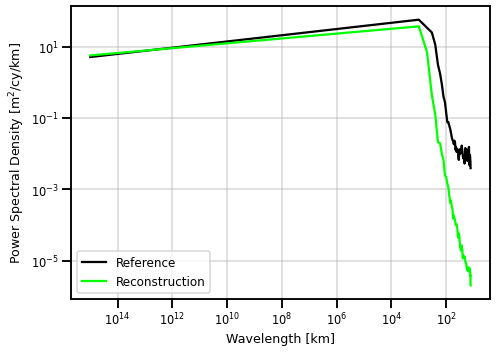

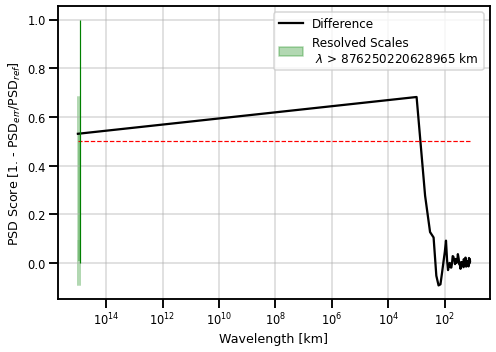

In [31]:

fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)
wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)